## Document Clustering

## Expectation Maximisation

### I. Background

Given a collection of documents, we would like to partition them into $K$ clusters by looking at the words of each documents and group the documents with similar words together in one cluster.

#### a. Maximum Likelihood Estimation (MLE) for Complete Data and Incomplete Data

##### Complete Data
The document clustering model with complete data assumes that we have:
- the collection of the documents $\{d_1,\dots,d_N\}$, 
- the document cluster assignments $\{z_1,\dots,z_N\}$. 

Then our likelihood function is given by 
$\begin{align}
p(d_1,z_1,\dots,d_N,z_N) &= \prod_{n=1}^N\prod_{k=1}^K p(z_n=k,d_n)^{z_{n,k}}\nonumber\\
&=\prod_{n=1}^N\prod_{k=1}^K \left(p(z_n=k)p(d_n|z_n=k)\right)^{z_{n,k}}\nonumber\\ 
&=\prod_{n=1}^N\prod_{k=1}^K \left(p(z_n=k)p(d_n|z_{n,k}=1)\right)^{z_{n,k}}\nonumber\\ 
&=\prod_{n=1}^N\prod_{k=1}^K\left(\varphi_{k}\prod_{w\in\mathcal{A}}\mu_{k,w}^{c(w,d_n)}\right)^{z_{n,k}}\nonumber\\ 
\end{align}
$

with 
- $z_n = (z_{n1},\dots,z_{nk}) \in \{0,1\}^k$ being the cluster assignment vector for the $n$-th document in which $z_{nk} = 1$ to denote the document belonging to cluster $k$ and zero otherwise,
- $\varphi_k$ is the $k$-th cluster proportion,
- $\mathcal{A}$ is the vocabulary of all the words in the collection of documents $\mathbf{d}$,
- $\mu_{k,w}$ is the probability of word $w$ in cluster $k$,
- $c(w,d)$ is the count of word $w$ in document $d$,
- the constraint that $\sum_{k=1}^K\varphi_k=1$ and $\sum_{w\in\mathcal{A}}\mu_{k,w}=1$

Then the log-likelihood function for complete data is given by:
$$\text{ln }p(d_1,z_1,\dots,d_N,z_N) = \sum_{n=1}^N\sum_{k=1}^Kz_{n,k}\left(\text{ln }\varphi_{k_n} + \sum_{w\in\mathcal{A}}c(w,d_n) \text{ln } \mu_{k_n,w}\right)$$

##### Incomplete Data
In the document clustering model with incomplete data, we assume that we only have the values of the documents $\mathbf{d}$, since in practice the cluster assignments $z_n$ are not given to us (e.g. latent). Thus, we have to find the marginal likelihood by summing over all possible cluster assignments. The probability of the observed documents is 
$\begin{align} 
p(d_1,\dots,d_N) &= \prod_{n=1}^N\sum_{k=1}^K p(z_n=k)\cdot p(d_n|z_n=k) \nonumber\\
&= \prod_{n=1}^N\sum_{k=1}^K \left(\varphi_{k_n}\prod_{w\in\mathcal{A}}\mu_{k_n,w}^{c(w,d_n)}\right) \nonumber
\end{align}$

The log-likelihood function is given by
$\begin{align}
\text{ln } p(d_1,\dots,d_N) &= \sum_{n=1}^N \text{ln} \sum_{k=1}^K \left(\varphi_{k_n}\prod_{w\in\mathcal{A}}\mu_{k_n,w}^{c(w,d_n)}\right) \nonumber 
\end{align}$

The maximum likelihood estimation (MLE) parameter for this case is harder to optimize because it involves the log of a sum over clusters, which arises from marginalizing the latent variables $z_n$. This structure makes the function non-convex, meaning that standard optimization algorithms like gradient descent can get stuck in local optima. As a result, this objective has no closed-form solution, motivating the use of the EM algorithm.

#### b. The Idea of EM Algorithm
The Expectation–Maximization (EM) algorithm is an iterative method for finding MLEs when the model has latent (unobserved, hidden) variables such as cluster assignments $z_n$. Starting from an initial guess $\left(\boldsymbol{\theta}^{(0)}\right)$, each iteration consists of:

- **E-step**: Use $\boldsymbol{\theta}^{(0)}$ to find the posterior probability of the latent variables given by
    $$p(\boldsymbol{Z}|\boldsymbol{D},\boldsymbol{\theta}^{(0)})$$
    Then use this posterior probability to compute the $Q$-function, which is the expected complete data log likelihood under this posterior probability:
    $$Q(\boldsymbol{\theta},\boldsymbol{\theta}^{(i)}) \coloneqq \sum_{\boldsymbol{Z}}p(\boldsymbol{Z}|\boldsymbol{D},\boldsymbol{\theta}^{(i)}) \text{ ln } p(\boldsymbol{Z},\boldsymbol{D}|\boldsymbol{\theta}) $$
    where $\text{ln }p(\boldsymbol{Z},\boldsymbol{D}|\boldsymbol{\theta})$ is the complete data log likelihood function. Here $\boldsymbol{\theta}^{(i)}$ is fixed and is the current estimate of the parameters. In contrast, $\boldsymbol{\theta}$ is a variable over which we are optimizing,

- **M-step**: Maximize the $Q$-function to find the updated parameter estimate $\boldsymbol{\theta}^{i+1}$
    $$\boldsymbol{\theta}^{(i+1)}
     = \arg\max_{\boldsymbol{\theta}}\;Q(\boldsymbol{\theta} ,\boldsymbol{\theta}^{(i)})$$

These two steps are repeated until the converge condition is met (e.g the log-likelihood or parameter changes are below a threshold). 

The EM algorithm guarantees that each iteration increases the incomplete data log likelihood $\text{ln } p(\boldsymbol{X}|\boldsymbol{\theta})$. This is because $Q(\boldsymbol{\theta},\boldsymbol{\theta}^{(i)})$ serves as a lower bound on 
$\text{ln } p(\boldsymbol{X}|\boldsymbol{\theta})$, and optimizing it effectively pushes the bound upward. 

### II. Deriving the EM Algorithm for Document Clustering
In the context of using EM algorithm to find the MLE parameters for document clustering, we start with the initial guess $\boldsymbol{\theta}^{(0)}$ where $\boldsymbol{\theta}\coloneqq (\boldsymbol{\varphi},\boldsymbol{\mu_1},\dots,\boldsymbol{\mu_K})$. Then the iteration steps for this case are as follows 

- **E-step**: 
    We derive the responsibility factor $\gamma(z_n,k)\coloneqq p\left(z_{n,k} = 1 |d_n,{\theta}^{(0)}\right)$ to build the $Q$-function as follows
    $\begin{align}
    \gamma(z_n,k) &\coloneqq p\left(z_{n,k} = 1 |d_n,{\theta}^{(0)}\right) \nonumber\\
    &= \frac{p\left(z_{n,k}=1,d_n|{\theta}^{(0)}\right)}{p\left(d_n|{\theta}^{(0)}\right)}\nonumber\\
    &= \frac{p\left(d_n|z_{n,k}=1,{\theta}^{(0)}\right)p\left(z_{n,k}=1|{\theta}^{(0)}\right)}{\sum_J p\left(z_n=j|{\theta}^{(0)}\right)\cdot p\left(d_n|z_n=j,{\theta}^{(0)}\right)}\nonumber\\
    &= \frac{\varphi_{k}\prod_{w\in\mathcal{A}}\mu_{k,w}^{c(w,d_n)}}{\sum_J\varphi_{j}\prod_{w\in\mathcal{A}}\mu_{j,w}^{c(w,d_n)}} \nonumber\\
    \end{align}$

    Then we can derive the $Q$-function using $\gamma(z_n,k)$ as follows:
    $\begin{align}
    Q(\boldsymbol{\theta}, \boldsymbol{\theta}^{(0)}) 
    &= \mathbb{E}_{Z \mid D, \boldsymbol{\theta}^{(0)}}[\ln p(D, Z \mid \boldsymbol{\theta})] \nonumber \\
    &= \sum_{n=1}^{N} \sum_{k=1}^{K} \gamma(z_n,k) \left[ \ln \varphi_k + \sum_{w \in \mathcal{A}} c(w, d_n) \ln \mu_{k,w} \right] \nonumber
    \end{align}$

- **M-step**:  
    We maximize the $Q$-function to find the new parameters 
    $$\boldsymbol{\theta}^{(i+1)}
     = \arg\max_{\boldsymbol{\theta}}\;Q(\boldsymbol{\theta} ,\boldsymbol{\theta}^{(i)})$$
    with respect to $\boldsymbol{\theta} = (\boldsymbol{\varphi}, \boldsymbol{\mu}_1, \dots, \boldsymbol{\mu}_K)$ under the constraints:
    
    $$\sum_{k=1}^{K} \varphi_k = 1, \qquad \sum_{w \in \mathcal{A}} \mu_{k,w} = 1 \quad \text{for each } k$$
   
    Using Lagrange multipliers we can find the analytical solution to update $\varphi_k$ and $\mu_{k,w}$ as follows
    - **Updating $\varphi_k$**:
    $\begin{align}
    \mathcal{L}(\boldsymbol{\varphi}, \lambda) &= \sum_{n=1}^{N} \sum_{k=1}^{K} \gamma(z_n,k) \ln \varphi_k + \lambda\left(1 - \sum_{k=1}^{K} \varphi_k\right) \nonumber \\
    \frac{\partial \mathcal{L}}{\partial \varphi_k} &= \sum_{n=1}^{N} \frac{\gamma(z_n,k)}{\varphi_k} - \lambda = 0 \nonumber \\
    \Rightarrow \varphi_k &= \frac{1}{N} \sum_{n=1}^{N} \gamma(z_n,k) = \frac{N_k}{N} \nonumber
    \end{align}$
    
    - **Updating $\mu_{k,w}$**:
    $\begin{align}
    \mathcal{L}(\boldsymbol{\mu}_k, \nu_k) &= \sum_{n=1}^{N} \gamma(z_n,k) \sum_{w \in \mathcal{A}} c(w,d_n) \ln \mu_{k,w} + \nu_k \left(1 - \sum_{w \in \mathcal{A}} \mu_{k,w} \right) \nonumber \\
    \frac{\partial \mathcal{L}}{\partial \mu_{k,w}} &= \sum_{n=1}^{N} \gamma(z_n,k) \frac{c(w,d_n)}{\mu_{k,w}} - \nu_k = 0 \nonumber \\
    \Rightarrow \mu_{k,w} &= \frac{\sum_{n=1}^{N} \gamma(z_n,k) c(w,d_n)}{\sum_{n=1}^{N} \gamma(z_n,k) \cdot \sum_{w' \in \mathcal{A}} c(w', d_n)} \nonumber
    \end{align}$

This completes one iteration of the EM algorithm. We repeat the E-step and M-step until convergence.

### III. Load Task2A.txt and Perform Text Preprocessing

Before implementing the EM algorithm, I read the document data and preprocessed it using `CountVectorizer`. This function will tokenize the documents, then form a matrix where the rows being the documents and the columns being the count of each words that show up in the corresponding documents. The words being counted are the ones that are in the vocabulary. I chose the argument `min_df = 5` which means that only words that have show up at least in 5 documents will be included in the vocabulary.


In [2]:
import pandas as pd 
import numpy as np

with open('Task2A.txt', 'r') as file:
    text = [line.strip() for line in file if line.strip() != '']
all([length == 2 for length in [len(line.split('\t')) for line in text]])
labels, articles = [line.split('\t')[0].strip() for line in text], [line.split('\t')[1].strip() for line in text]
docs = pd.DataFrame(data = zip(labels,articles), columns=['label', 'article'])
docs.label = docs.label.astype('category')
docs.head()

,label,article
0,sci.crypt,ripem frequently asked questions archive name ...
1,sci.crypt,ripem frequently asked questions archive name ...
2,sci.crypt,ripem frequently noted vulnerabilities archive...
3,sci.crypt,certifying authority question answered if you ...
4,sci.crypt,rubber hose cryptanalysis some sick part of me...


In [25]:
# Perform Text Preprocessing

from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(lowercase=True,
                     stop_words='english',
                     min_df=5)
features = cv.fit_transform(raw_documents=articles)
features.shape

(2373, 8094)

### IV. Implement the EM Algorithm

 I implement the EM algorithm for document clustering below. First, I implement the soft EM algorithm, then I also implement the hard EM algorithm.

In hard clustering we *harden* the soft probabilities assignment in the **E-step** by using 

$$z_n = \arg\max_k \gamma(z_n, k)$$

which makes our $\gamma(z_n)$ into $\gamma(z_n) = [0, \dots, 1, \dots, 0]$. This equation means that each data point will only be assigned to one cluster with have the highest probability.

Since $\gamma(z_n, k) \in \{0,1\}$, in the **M-step**, the expected complete-data log-likelihood simplifies to:

$$Q(\boldsymbol{\theta}, \boldsymbol{\theta}^{(0)}) = \sum_{n=1}^N \left( \ln \varphi_{k} + \sum_{w \in \mathcal{A}} c(w, d_n) \ln \mu_{k,w} \right)$$

In [ ]:
from scipy.special import logsumexp
class SoftDocClus: 
    def __init__(self, K, tau_max=500, epsilon=0.0001, random_state=None, verbose=False):
        self.K = K               # number of clusters
        self.tau_max = tau_max   # max number of iterations
        self.epsilon = epsilon   # minimum acceptable error rate
        self.random_state = random_state
        np.random.seed(self.random_state)
        self.verbose = verbose

    def get_params(self, deep=False):
        return {'K': self.K,
         'tau_max': self.tau_max,
         'epsilon': self.epsilon,
         'random_state': self.random_state}
    
    def __str__(self):
        params = self.get_params()
        return 'SoftDocClus({0})'.format(','.join(['='.join([key, str(params[key])]) for key in params.keys()]))

    def __repr__(self):
        return self.__str__()
                
    def fit(self, X, verbose=False):
        N, A = X.shape # shape is (the number of document) x (the size of vocabulary)

        # initialization
        self.varphi_hat = np.array([1/self.K] * self.K) # assign same probability of each cluster
        self.Mu_hat = np.random.dirichlet(alpha=np.ones(A), size= self.K) # assign probability using dirichlet function, shape is (the number of clusters) x (the size of vocabulary)
        gamma = np.zeros((N,self.K)) # shape is (the number of document) x (the number of clusters)
        Mu_old = self.Mu_hat.copy() # to check convergence

        self.Mu_historic_ = np.zeros(shape= (self.K, A, self.tau_max)) 
        self.gamma_historic_ = np.zeros(shape=(N, self.K, self.tau_max))

        terminate = False
        tau = 0

        while (not terminate):
            # ------ E-step ------
            # use the log-sum-exp trick to avoid numerical instability
            log_Mu_hat = np.log(self.Mu_hat + 1e-12)  # add epsilon to avoid log(0)
            log_phi = np.log(self.varphi_hat + 1e-12)  # same for priors
            log_gamma =  X.dot(log_Mu_hat.T) + log_phi 

            lse = logsumexp(log_gamma, axis=1, keepdims=True)      # per‐document normalizer
            gamma = np.exp(log_gamma - lse)

            self.gamma_historic_[:, :, tau] = gamma

            # ------ M-step ------
            # use the analytical solution to update varphi and mu
            self.varphi_hat = gamma.sum(axis=0)/N  # Nk/N
            
            Mu_numerator =  (gamma.T @ X)
            Mu_denom = Mu_numerator.sum(axis = 1, keepdims = True)
            self.Mu_hat = Mu_numerator / Mu_denom

            self.Mu_historic_[:,:,tau] = self.Mu_hat

            # increase iteration counter
            tau +=1

            # convergence check
            terminate = ((tau == self.tau_max) or np.allclose(self.Mu_hat, Mu_old, rtol=self.epsilon))
           
            # if not converging yet, update the mu for next iteration
            Mu_old = self.Mu_hat.copy()

        self.gamma_historic_ = self.gamma_historic_[:, :, :tau+1]
        self.Mu_historic_    = self.Mu_historic_[:, :, :tau+1]

        # check for convergence / termination criteria        
        diff = np.max(np.abs(self.Mu_hat - Mu_old))
        if self.verbose and diff < self.epsilon:
            print(f"Soft Clustering converged in {tau} iterations")

        return self
                
    def predict_proba(self, x):
        log_Mu_hat = np.log(self.Mu_hat + 1e-12)  # add epsilon to avoid log(0)
        log_phi = np.log(self.varphi_hat + 1e-12)  # same for priors
        log_gamma_num =  x.dot(log_Mu_hat.T) + log_phi 

        lse = logsumexp(log_gamma_num, axis=1, keepdims=True)      # per‐document normalizer
        gamma = np.exp(log_gamma_num - lse)
        return gamma

    def predict(self, x):
        probs = self.predict_proba(x)
        preds = np.argmax(probs, axis=1)
        return preds


In [ ]:
from scipy.special import logsumexp
from scipy.sparse import csr_matrix

class HardDocClus: 
    def __init__(self, K, tau_max=500, epsilon=0.0001, random_state=None, set_initial = False):
        self.K = K               # number of clusters
        self.tau_max = tau_max   # max number of iterations
        self.epsilon = epsilon   # minimum acceptable error rate
        self.random_state = random_state
        np.random.seed(self.random_state)
        self.set_initial = set_initial

    def get_params(self, deep=False):
        return {'K': self.K,
         'tau_max': self.tau_max,
         'epsilon': self.epsilon,
         'random_state': self.random_state}
    
    def __str__(self):
        params = self.get_params()
        return 'HardDocClus({0})'.format(','.join(['='.join([key, str(params[key])]) for key in params.keys()]))

    def __repr__(self):
        return self.__str__()
                
    def fit(self, X, verbose=False):
        N, A = X.shape # shape is (the number of document) x (the size of vocabulary)

        # initialization
        self.varphi_hat = np.array([1/self.K] * self.K) # assign same probability of each cluster
        self.Mu_hat = np.random.dirichlet(alpha=np.ones(A), size= self.K) # assign probability using dirichlet function, shape is (the number of clusters) x (the size of vocabulary)
        
        ## if set_initial = True, set initial varphi and mu from soft EM clustering
        if self.set_initial:
            soft_model = SoftDocClus(K=self.K, random_state=self.random_state).fit(X)
            self.varphi_hat = soft_model.varphi_hat
            self.Mu_hat = soft_model.Mu_hat
        
        gamma = np.zeros((N,self.K)) # shape is (the number of document) x (the number of clusters)
        Mu_old = self.Mu_hat.copy() # to check convergence

        self.Mu_historic_ = np.zeros(shape= (self.K, A, self.tau_max))
        self.gamma_historic_ = np.zeros(shape=(N, self.K, self.tau_max))

        terminate = False
        tau = 0

        while (not terminate):
            # ------ E-step ------
            # use the log-sum-exp trick to avoid numerical instability
            log_Mu_hat = np.log(self.Mu_hat + 1e-12)  # add epsilon to avoid log(0)
            log_phi = np.log(self.varphi_hat + 1e-12)  # same for priors
            log_gamma =  X.dot(log_Mu_hat.T) + log_phi 

            lse = logsumexp(log_gamma, axis=1, keepdims=True)      # per‐document normalizer
            gamma = np.exp(log_gamma - lse)

            max_clip_function = lambda x:  np.array([1 if i== x.argmax() else 0 for i in range(len(x))])
            z_n_hat = np.array(list(map(max_clip_function, gamma)), dtype='float32')
            gamma = z_n_hat
            self.gamma_historic_[:, :, tau] = z_n_hat


            # ------ M-step ------
            # use the analytical solution to update varphi and mu
            self.varphi_hat = gamma.sum(axis=0)/N  # Nk/N
            
            Mu_numerator =  (gamma.T @ X)
            Mu_denom = Mu_numerator.sum(axis = 1, keepdims = True)
            self.Mu_hat = Mu_numerator / Mu_denom

            self.Mu_historic_[:,:,tau] = self.Mu_hat

            # increase iteration counter
            tau +=1

            # convergence check
            terminate = ((tau == self.tau_max) or np.allclose(self.Mu_hat, Mu_old, rtol=self.epsilon))
           
            # if not converging yet, update the mu for next iteration
            Mu_old = self.Mu_hat.copy()

        self.gamma_historic_ = self.gamma_historic_[:, :, :tau+1]
        self.Mu_historic_    = self.Mu_historic_[:, :, :tau+1]
                
        # check for convergence / termination criteria       
        diff = np.max(np.abs(self.Mu_hat - Mu_old))
        if verbose: print(f"Iteration {tau}, max diff in Mu: {diff}")
        if diff < self.epsilon and self.set_initial == True:
            print(f"Hard Clustering with non-random initial converged in {tau} iterations")
        elif diff < self.epsilon and self.set_initial == False:
            print(f"Hard Clustering converged in {tau} iterations")

        return self
        
    def predict_proba(self, x):
        log_Mu_hat = np.log(self.Mu_hat + 1e-12)  # add epsilon to avoid log(0)
        log_phi = np.log(self.varphi_hat + 1e-12)  # same for priors
        log_gamma_num =  x.dot(log_Mu_hat.T) + log_phi 

        lse = logsumexp(log_gamma_num, axis=1, keepdims=True)      # per‐document normalizer
        gamma = np.exp(log_gamma_num - lse)
        return gamma
    
    def predict(self, x):
        probs = self.predict_proba(x)
        preds = np.argmax(probs, axis=1)
        return preds


### V. Run the Hard Clustering and Soft Clustering, then Perform a PCA on the Clusterings

Now to test the implementation of both algorithm, I run the clusterings for $K=4$, then perform a PCA to reduce the dimension into two major components. I also perform feature extraction using the Term Frequency-Inverse Document Frequency (TFIDF) which will convert the word count into weighted ones. Since I set the norm argument into `l2`, thus I do not need to normalize the data.

Soft Clustering converged in 187 iterations
Hard Clustering converged in 7 iterations
Hard Clustering with non-random initial converged in 2 iterations


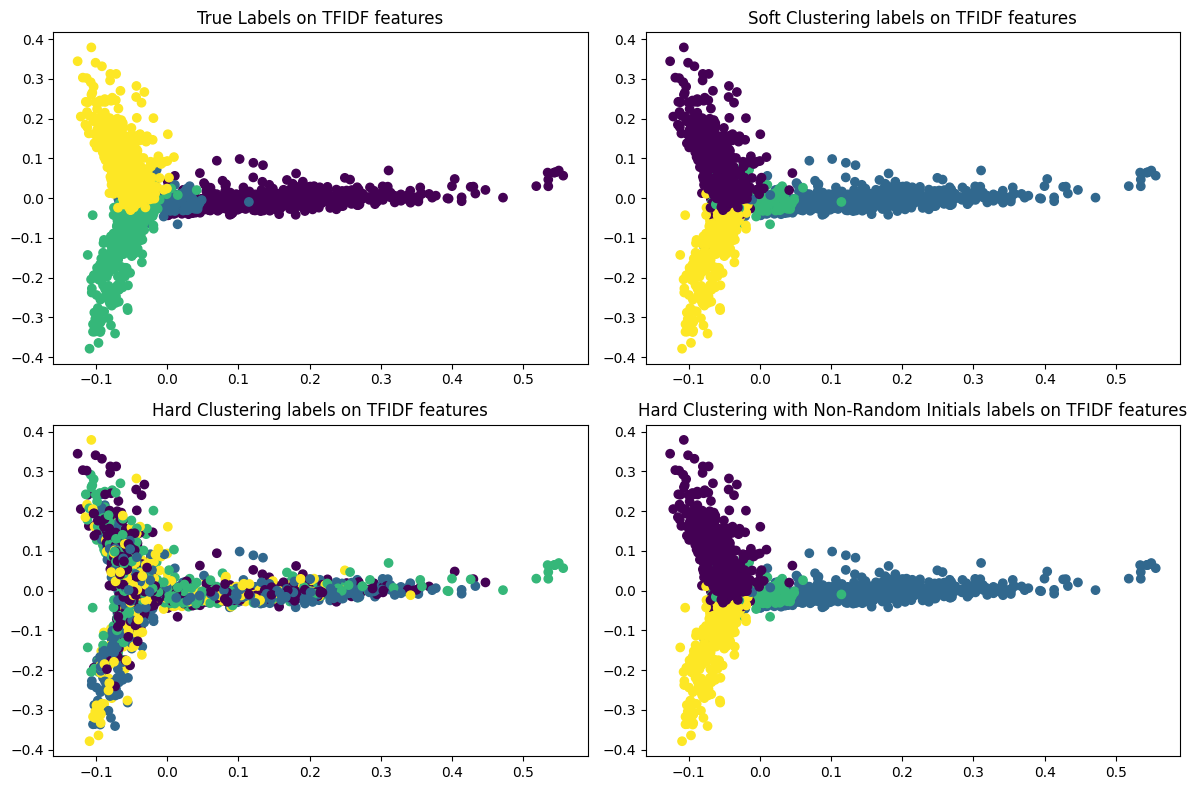

In [118]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline

tfidf = TfidfVectorizer(lowercase=True,
                     stop_words='english',
                     min_df=5,
                    norm='l2')  # note that specifying the norm will normalise the data for us


features = tfidf.fit_transform(raw_documents=docs.article.values)

# Run soft clustering
soft_EM = SoftDocClus(K=4, random_state=3, verbose=True)
soft_pipeline = make_pipeline(tfidf, soft_EM)
soft_pipeline.fit(articles)

# Run hard clustering
hard_EM = HardDocClus(K=4,random_state=3)
hard_pipeline = make_pipeline(tfidf,hard_EM)
hard_pipeline.fit(articles)

# Run hard clustering with initial phi and mu set to soft clustering phi and mu
hard_EM_set_initial = HardDocClus(K=4,random_state=3,set_initial=True)
hard_initial_pipeline = make_pipeline(tfidf,hard_EM_set_initial)
hard_initial_pipeline.fit(articles)

## perform pca
pca = PCA(n_components=2)
_2D_features = pca.fit_transform(features.toarray())

## plot the outcome


_, axs = plt.subplots(2, 2, figsize=(12, 8), tight_layout=True)
axs = axs.flatten()

# soft clustering
axs[1].scatter(x=_2D_features[:,0],y=_2D_features[:,1], c=soft_EM.predict(features))
axs[1].set_title('Soft Clustering labels on TFIDF features')

# hard clustering
axs[2].scatter(x=_2D_features[:,0],y=_2D_features[:,1], c=hard_EM.predict(features))
axs[2].set_title('Hard Clustering labels on TFIDF features')

# clustering with non-random initial phi and mu
axs[3].scatter(x=_2D_features[:,0],y=_2D_features[:,1], c=hard_EM_set_initial.predict(features))
axs[3].set_title('Hard Clustering with Non-Random Initials labels on TFIDF features')

## plot the original data
axs[0].scatter(x=_2D_features[:,0],y=_2D_features[:,1], c=docs.label.cat.codes)
axs[0].set_title('True Labels on TFIDF features')
plt.show()

### Difference between Hard and Soft Clustering

Since there are only hard assignments of cluster for data point in hard EM, once a document is assigned to a cluster, it contributes only to that cluster in the M-step. Thus if in the early iteration the data points get a bad assignment, then these misclassification will be hard to fix. As a result, the cluster mean $\mu$ will get pulled in bad directions. The algorithm might also get stuck in bad local optima, reinforcing the wrong clusters. Meanwhile, soft EM avoids this by assigning probabilities, allowing uncertainty and gradual refinement. Though this result in a slower convergence, but when we see the plot result, it is clear the soft EM worth the wait. 

Another thing to note is that, in line with the explanation above, the random initialization for hard EM did not converge well as shown in the plot. Thus to fix it, I tried to use the parameters from soft EM to initialize the parameters for hard EM. This results in a nice clustering, really close to the soft EM result. This proves that hard clustering is really sensitive to initialization as mentioned above.
